# Final Project - Reinforcements Learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Avraham Raviv, 204355390
<br>
Student 2: Yevgeni Berkovitch, 317079234
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban

!imageio_download_bin ffmpeg

# Imports

In [3]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt

import base64
import imageio
from pyvirtualdisplay import Display
from IPython.display import HTML

import gym
from gym import error, spaces, utils
from soko_pap import *

from collections import deque
from queue import PriorityQueue

from keras.models import Sequential
from keras.layers import Dense

In [4]:
%matplotlib inline

In [5]:
imageio.plugins.ffmpeg.download()

In [6]:
from gym import logger as gymlogger
gymlogger.set_level(40) # error only

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [7]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)

# Solution

In [8]:
class SOK_Agent:
    def __init__(self):
        # Construct DQN models
        self.state_size = (25,) 
        self.action_size = 8
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.batch_size = 8
        
        # Replay buffers
        self.replay_buffer = deque(maxlen=1500)
        self.prioritized_replay_buffer = deque(maxlen=500)
        self.prioritized_replay_batch = 50        
        
        # Hyperparameters
        self.gamma = 0.9
        self.epsilon = 1.0   
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.995
        self.epsilon_update_rate = 10
        self.replay_rate = 10
        self.update_beta = 0.99

        self.verbosity = 100 

    def _build_model(self):
        model = Sequential()
        model.add(Dense(25, input_shape=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber', optimizer="adam")        
        return model

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append([state, action, reward, next_state, done])    
        
    def copy_to_prioritized_buffer(self, n):
        for i in range(n):
            self.prioritized_replay_buffer.append(self.replay_buffer[-1-i])  

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0]) 

    def replay(self):        
        minibatch = random.sample(self.replay_buffer, self.batch_size//2) 
        minibatch.extend(random.sample(self.prioritized_replay_buffer, self.batch_size//2))
        
        states = np.zeros((self.batch_size, self.state_size[0]))
        targets = np.zeros((self.batch_size, self.action_size))
        for i, (state, action, reward, next_state, done) in enumerate(minibatch): 
            states[i] = state
            targets[i] = self.model.predict(state, verbose=0)
            if done:
                targets[i][action] = reward
            else:
                max_action = np.argmax(self.model.predict(next_state)[0])
                targets[i][action] = reward + self.gamma*self.target_model.predict(next_state)[0][max_action]
                
        self.model.fit(states, targets, epochs=10, verbose=0) 
        
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay
        
    def update_target_model(self):
        model_w = self.model.get_weights()
        target_model_w = self.target_model.get_weights()
        updated_target_model_w = []
        for i in range(len(model_w)):
            updated_target_model_w.append(self.update_beta*target_model_w[i] + (1-self.update_beta)*model_w[i])
        self.target_model.set_weights(updated_target_model_w)    
            
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [9]:
def process_frame(frame):
    f = frame[16:96, 16:96, 0]   
    f = f.reshape(5, 16, 5, 16).max(axis=(1, 3))
    f = f.flatten()
    f = f / 255
    return np.expand_dims(f, axis=0)

## Training

In [11]:
max_episodes = 10000
max_steps = 500

def init_sok():
    random.seed(2)
    sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1)
    sok.set_maxsteps(max_steps)
    return sok

In [12]:
agent = SOK_Agent()
successes_before_train = 5
successful_episodes = 0
continuous_successes_goal = 10
continuous_successes = 0

steps_per_episode = []

for e in range(max_episodes):
    if continuous_successes >= continuous_successes_goal:
        print("Agent training finished!")
        break
    
    print("Episode: %d" % (e+1))
    
    sok = init_sok()
    state = process_frame(sok.get_image('rgb_array'))
    random.seed(e)
    
    for step in range(sok.max_steps):
        action = agent.act(state)
        if action < 4:
            next_state, reward, done, _ = sok.step(action+1) 
        else:
            next_state, reward, done, _ = sok.step(action+5)         
        next_state = process_frame(next_state)
        
        if reward > 0:
            reward = 1.0
        
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state  
        
        if successful_episodes >= successes_before_train:
            if (step+1) % agent.replay_rate == 0:
                agent.replay() 
                agent.update_target_model()
                agent.update_epsilon()
            if (step+1) % agent.verbosity == 0: 
                print("Episode %d Steps %d Epsilon %.4f" % (e+1, step+1, agent.epsilon)) 
        
        if done:            
            if 3 in sok.room_state:
                successful_episodes += 1
                continuous_successes += 1
                print("SOLVED! Episode %d Steps: %d Epsilon %.4f" % (e+1, step+1, agent.epsilon)) 
                agent.copy_to_prioritized_buffer(min(agent.prioritized_replay_batch, step+1))
            else:
                continuous_successes = 0
                
            steps_per_episode.append(step+1)
            agent.save("exp1_episode%d.h5" % (e+1))
            
            break

Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
SOLVED! Episode 23 Steps: 438 Epsilon 1.0000
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
SOLVED! Episode 29 Steps: 488 Epsilon 1.0000
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
SOLVED! Episode 57 Steps: 466 Epsilon 1.0000
Episode: 58
Episode: 59
SOLVED! Episode 59 Steps: 454 Epsilon 1.0000
Episode: 60
Episode: 61
Episode: 62
Episode: 63
SOLVED! Episode 63 Steps: 226 Epsilon 1.0000
Episode: 64
Episode 64 Steps

Episode 101 Steps 400 Epsilon 0.2988
Episode 101 Steps 500 Epsilon 0.2988
Episode: 102
Episode 102 Steps 100 Epsilon 0.2988
Episode 102 Steps 200 Epsilon 0.2988
Episode 102 Steps 300 Epsilon 0.2988
Episode 102 Steps 400 Epsilon 0.2988
Episode 102 Steps 500 Epsilon 0.2988
Episode: 103
Episode 103 Steps 100 Epsilon 0.2988
Episode 103 Steps 200 Epsilon 0.2988
Episode 103 Steps 300 Epsilon 0.2988
Episode 103 Steps 400 Epsilon 0.2988
Episode 103 Steps 500 Epsilon 0.2988
Episode: 104
Episode 104 Steps 100 Epsilon 0.2988
Episode 104 Steps 200 Epsilon 0.2988
Episode 104 Steps 300 Epsilon 0.2988
Episode 104 Steps 400 Epsilon 0.2988
Episode 104 Steps 500 Epsilon 0.2988
Episode: 105
Episode 105 Steps 100 Epsilon 0.2988
Episode 105 Steps 200 Epsilon 0.2988
Episode 105 Steps 300 Epsilon 0.2988
Episode 105 Steps 400 Epsilon 0.2988
Episode 105 Steps 500 Epsilon 0.2988
Episode: 106
SOLVED! Episode 106 Steps: 72 Epsilon 0.2988
Episode: 107
Episode 107 Steps 100 Epsilon 0.2988
Episode 107 Steps 200 Epsi

Episode 149 Steps 100 Epsilon 0.2988
Episode 149 Steps 200 Epsilon 0.2988
Episode 149 Steps 300 Epsilon 0.2988
Episode 149 Steps 400 Epsilon 0.2988
Episode 149 Steps 500 Epsilon 0.2988
Episode: 150
Episode 150 Steps 100 Epsilon 0.2988
Episode 150 Steps 200 Epsilon 0.2988
SOLVED! Episode 150 Steps: 250 Epsilon 0.2988
Episode: 151
Episode 151 Steps 100 Epsilon 0.2988
Episode 151 Steps 200 Epsilon 0.2988
SOLVED! Episode 151 Steps: 246 Epsilon 0.2988
Episode: 152
Episode 152 Steps 100 Epsilon 0.2988
Episode 152 Steps 200 Epsilon 0.2988
Episode 152 Steps 300 Epsilon 0.2988
Episode 152 Steps 400 Epsilon 0.2988
Episode 152 Steps 500 Epsilon 0.2988
Episode: 153
Episode 153 Steps 100 Epsilon 0.2988
Episode 153 Steps 200 Epsilon 0.2988
Episode 153 Steps 300 Epsilon 0.2988
Episode 153 Steps 400 Epsilon 0.2988
Episode 153 Steps 500 Epsilon 0.2988
Episode: 154
Episode 154 Steps 100 Epsilon 0.2988
Episode 154 Steps 200 Epsilon 0.2988
Episode 154 Steps 300 Epsilon 0.2988
Episode 154 Steps 400 Epsilon

Episode 197 Steps 300 Epsilon 0.2988
Episode 197 Steps 400 Epsilon 0.2988
Episode 197 Steps 500 Epsilon 0.2988
Episode: 198
Episode 198 Steps 100 Epsilon 0.2988
Episode 198 Steps 200 Epsilon 0.2988
Episode 198 Steps 300 Epsilon 0.2988
Episode 198 Steps 400 Epsilon 0.2988
Episode 198 Steps 500 Epsilon 0.2988
Episode: 199
Episode 199 Steps 100 Epsilon 0.2988
SOLVED! Episode 199 Steps: 138 Epsilon 0.2988
Episode: 200
Episode 200 Steps 100 Epsilon 0.2988
Episode 200 Steps 200 Epsilon 0.2988
Episode 200 Steps 300 Epsilon 0.2988
Episode 200 Steps 400 Epsilon 0.2988
Episode 200 Steps 500 Epsilon 0.2988
Episode: 201
Episode 201 Steps 100 Epsilon 0.2988
Episode 201 Steps 200 Epsilon 0.2988
Episode 201 Steps 300 Epsilon 0.2988
Episode 201 Steps 400 Epsilon 0.2988
Episode 201 Steps 500 Epsilon 0.2988
Episode: 202
Episode 202 Steps 100 Epsilon 0.2988
Episode 202 Steps 200 Epsilon 0.2988
Episode 202 Steps 300 Epsilon 0.2988
Episode 202 Steps 400 Epsilon 0.2988
Episode 202 Steps 500 Epsilon 0.2988
E

Episode 245 Steps 300 Epsilon 0.2988
Episode 245 Steps 400 Epsilon 0.2988
Episode 245 Steps 500 Epsilon 0.2988
Episode: 246
Episode 246 Steps 100 Epsilon 0.2988
Episode 246 Steps 200 Epsilon 0.2988
Episode 246 Steps 300 Epsilon 0.2988
Episode 246 Steps 400 Epsilon 0.2988
Episode 246 Steps 500 Epsilon 0.2988
Episode: 247
Episode 247 Steps 100 Epsilon 0.2988
Episode 247 Steps 200 Epsilon 0.2988
Episode 247 Steps 300 Epsilon 0.2988
Episode 247 Steps 400 Epsilon 0.2988
Episode 247 Steps 500 Epsilon 0.2988
Episode: 248
SOLVED! Episode 248 Steps: 72 Epsilon 0.2988
Episode: 249
Episode 249 Steps 100 Epsilon 0.2988
Episode 249 Steps 200 Epsilon 0.2988
Episode 249 Steps 300 Epsilon 0.2988
Episode 249 Steps 400 Epsilon 0.2988
Episode 249 Steps 500 Epsilon 0.2988
Episode: 250
Episode 250 Steps 100 Epsilon 0.2988
Episode 250 Steps 200 Epsilon 0.2988
Episode 250 Steps 300 Epsilon 0.2988
Episode 250 Steps 400 Epsilon 0.2988
Episode 250 Steps 500 Epsilon 0.2988
Episode: 251
Episode 251 Steps 100 Epsi

Episode 290 Steps 500 Epsilon 0.2988
Episode: 291
SOLVED! Episode 291 Steps: 9 Epsilon 0.2988
Episode: 292
SOLVED! Episode 292 Steps: 9 Epsilon 0.2988
Episode: 293
SOLVED! Episode 293 Steps: 9 Epsilon 0.2988
Episode: 294
SOLVED! Episode 294 Steps: 9 Epsilon 0.2988
Episode: 295
SOLVED! Episode 295 Steps: 9 Epsilon 0.2988
Episode: 296
SOLVED! Episode 296 Steps: 9 Epsilon 0.2988
Episode: 297
SOLVED! Episode 297 Steps: 9 Epsilon 0.2988
Episode: 298
SOLVED! Episode 298 Steps: 9 Epsilon 0.2988
Episode: 299
SOLVED! Episode 299 Steps: 9 Epsilon 0.2988
Episode: 300
SOLVED! Episode 300 Steps: 9 Epsilon 0.2988
Agent training finished!


## Charts

In [ ]:
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax.hist(x, 50)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

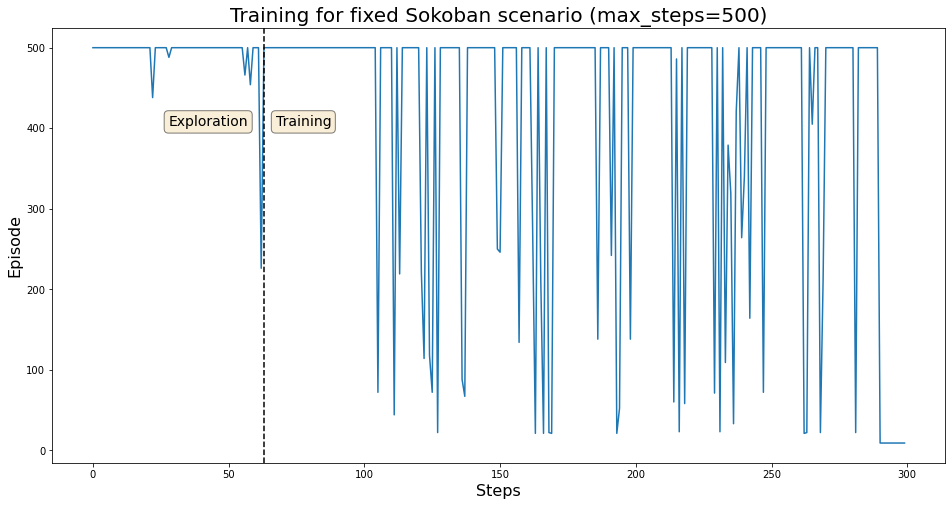

In [47]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(list(range(len(steps_per_episode))), steps_per_episode)
plt.title("Training for fixed Sokoban scenario (max_steps=500)", fontsize=20)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("Episode", fontsize=16)
plt.axvline(63, color='k', linestyle='--', label='Start')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.13, 0.8, "Exploration", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.25, 0.8, "Training", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.show()

## Demo

In [48]:
sok = init_sok()
sok.epsilon = 0

start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'

state = sok.get_image('rgb_array')

with imageio.get_writer(video_filename, fps=10) as video:
    while (iter < 10) or not done:
        time_passed = int(time.time() - start_time)
        if done or time_passed > 3:
            break
        iter +=1
        action = agent.act(process_frame(state))
        
        if action < 4:
            action += 1
        else:
            action += 5
        
        state, reward, done, info = sok.step(action)
        video.append_data(sok.render(mode='rgb_array'))
        
embed_mp4(video_filename)

In [ ]:
import tensorflow as tf

oi = tf.keras.initializers.Orthogonal()
ortho_layer = tf.keras.layers.Dense(
    32, kernel_initializer=oi
)

In [ ]:
opt_adam = optimizers.adam(clipnorm=1.)
opt_adam = optimizers.adam(clipvalue=0.5)